Alvaro Viejo (100451677), Rodrigo Oliver (100451788), Oscar Montoya (100451858), Miguel Ángel Ponce (100451309)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm as normal
from scipy.stats import multivariate_normal as mvn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from IPython.core.display import Image, display

C:\Users\tacua\AppData\Local\Temp\ipykernel_32344\3464626361.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams['font.size'] = 12


## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2020

&nbsp;
&nbsp;
&nbsp;
# Lab 6. Mixture Models

&nbsp;
&nbsp;
&nbsp;

**Ignacio Peis**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='https://www.uc3m.es/ss/Satellite?blobcol=urldata&blobkey=id&blobtable=MungoBlobs&blobwhere=1371573953235&ssbinary=true' width=400 />


# Introduction

In this lab you will study two mixure models: the Gaussian Mixture Model (GMM) for real-valued data and the Mixture of Bernouillis for data in the range $[0, 1]$. We assume that each dataset $\mathcal{D}$ is composed by $N$ observations $\mathbf{x}_i$ with dimension $D$, and, for the Gaussian part, $\mathbf{x}_i \in \mathbb{R}$, while for the second part, $\mathbf{x}_i \in [0, 1]$.

## Mixture models

 Mixture Models are a special class of probabilistic generative models that can be used for both **density estimation** and **clustering**. Given a set of multidimensional observations, mixture models assume that observed variables are correlated because they arise from a hidden common "cause" or **latent variable** that is discrete (it can only take a finite number of values). Instead of assuming that every sample come from the same distribution, in a mixture model, each observations is expected to "belong" to one among $K$ distributions. Thus, there exist a probability for an observation to has been generated by each component.

We say that a distribution $p(\mathbf{x})$ is a **mixture of $K$ component** distributions
$p_{1}(\mathbf{x}), p_{2}(\mathbf{x}),\ldots,p_{K}(\mathbf{x})$ if

\begin{align}
p(\mathbf{x})=\sum_{k=1}^{K} \pi_k p_{k}(\mathbf{x}),
\end{align}
with $\pi_k$ being the **mixing weights**, $\pi_k>0$, $\sum_k \pi_k =1$. An equivalent way to understad a Mixture Model is to think that every sample $\mathbf{x}$ is generated by first sampling a discrete, hidden R.V. $z\in\{1,\ldots,K\}$ with probabilities $\pi_1,\ldots,\pi_K$, and then generate a sample $\mathbf{x}$ from $p_k(\mathbf{x})$. Namely,
\begin{align}
p(\mathbf{x})=\int_{z} p(\mathbf{x},z) dz = \sum_{k=1}^{K} \pi_k p_{k}(\mathbf{x}),
\end{align}
where 
\begin{align}
p(\mathbf{x},z) = \prod_{k=1}^{K} \left(\pi_k ~p_{k}(\mathbf{x})\right)^{\mathbb{1} [z==k]}
\end{align}

## The EM algorithm

In this type of models, we denote with $\theta$ all the parameters of the model, including parameters for each component of the distribution (mean and variances for Gaussian, $a$ and $b$ for Bernouilli, etc.) and mixing weights $\pi_k$ (probabilities of each component). For example, for a mixture of Gaussians:
\begin{equation}
\theta=\{ \boldsymbol{\pi}, \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0, \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\mu}_K, \boldsymbol{\Sigma}_K \}
\end{equation}
The final goal is to obtain the parameters that best explain the data, and for that purpose, we have to maximize the log likelihood of the observed data, which is given by:
\begin{align}
\ell(\mathbf{\theta})=\sum_{i=1}^{N} \log p(\mathbf{x}^{(i)} | \theta) = \sum_{i=1}^{N} \log \left[\sum_{z^{(i)}} p(\mathbf{x}^{(i)},z^{(i)}|\mathbf{\theta})\right]
\end{align}
Unfortunately this is strongly hard to optimize, since the log cannot be pushed inside the sum. What can we do? The **Expectation Maximization (EM)** algorithm gets around this problem as follows. The **EM** algorithm provides a simple iterative solution that guarantees to converge to a **local mode**. The steps are the following. First, define the **complete data log likelihood** to be the one that includes $z^{(i)}$:
\begin{align}
\ell_c(\mathbf{\theta})=\sum_{i=1}^{N} \log  p(\mathbf{x}^{(i)},z^{(i)}|\mathbf{\theta}) = \sum_{i=1}^{N} \sum_{k=1}^{K}  \mathbb{I} [z==k] \left[ \log (\pi_k) + \log p_{k}(\mathbf{x})\right]
\end{align}
Now we have the sum out of the logarithm. Nevertheless, the new problem is: how we compute $\mathbb{I} [z==k]$ if $z$ is hidden (i.e., we don't know $z$)? The solution is to compute the expectation over $z$: that consists on taking into account the whole discrete possibilities of $z$ (informally speaking: which happens if $z$ selects each component $k$). We call this the expected complete data log likelihood, which is given by:

\begin{align}
\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})&= \mathbb{E}_{z^{(i)}\sim p(z^{(i)}|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1})} \left[ \ell_c(\mathbf{\theta}) \right]=\sum_{i=1}^{N} \mathbb{E}_{z^{(i)}\sim p(z^{(i)}|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1})}\left[\log p(\mathbf{x}^{(i)},z^{(i)})\right]= \\
&= \sum_{i=1}^{N}\sum_{k=1}^K p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1}) \left[\log \pi_k +\log p(\mathbf{x}^{(i)}|\theta_k)\right],
\end{align}

You can notice that we are taking expectations over $z$ from its posterior distribution $p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1})$, instead of the prior ($p(z^{(i)}=k)=\pi_k$), to include knowledge from data. This posterior of each component, given the data, can be obtained by applying the Bayes rule:
\begin{align}
p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1}) \triangleq r_{ik} = \frac{\pi_{(k,t-1)} p(\mathbf{x}^{(i)}| \theta_{(k,t-1)} )}{\sum_{q=1}^K \pi_{(q,t-1)} p(\mathbf{x}^{(i)}|\theta_{(q,t-1)})}
\end{align}

The values $r_{ik}$ are known as the responsibility that cluster $k$ takes for data point $i$ (given $\mathbf{\theta}_{t-1}$). This is the posterior probability that cluster $k$ generated $\mathbf{x}_i$.

As you may appreciate, all these expressions depend on the last value of the parameters of the model: $\theta_{t-1}$. The EM is an iterative algorithm divided into two steps at each iteration, and each iteration depends on the last parameters update. Therefore, we need to initialize the parameters at the beginning.



### E-Step
In the E-step, we just compute the the expected complete data log likelihood $\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})$ to see how probable is the data given the last value of the parameters. As we know $\mathbf{\theta}_{t-1}$, we are going to obtain a function over $\theta$ (the new parameters that we want to obtain).


### M-Step
In the M step, we optimize $\mathcal{Q}$ w.r.t. $\theta$ to update with the new optimal the parameters:
\begin{equation}
\hat{\pi}_k = \frac{\partial \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})}{\partial \pi_k }
\end{equation}
For the Gaussian case, for example, we must compute:
\begin{equation}
\hat{\boldsymbol{\mu}}_k = \frac{\partial \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})}{\partial \boldsymbol{\mu}_k }  \qquad  \hat{\boldsymbol{\Sigma}}_k = \frac{\partial \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})}{\partial \boldsymbol{\Sigma}_k }
\end{equation}
*We have to obtain the same for all the components, i.e. for each $k$.*






# 1. Gaussian Mixture Model

A Gaussian Mixture Model (GMM) is composed by $K$ Gaussian components, with the set of parameters $\theta$ composed by component parameters $\{\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$ for $k=1, ..., K$ and mixing weights $\boldsymbol{\pi}=[\pi_0, \pi_1, ..., \pi_K]$. 

For the GMM, the EM steps are defined as following:

### E-Step for GMMs
The expected complete likelihood and the responsibilities are given by:
\begin{gather}
\mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1}) =
\sum_{i=1}^{N}\sum_{k=1}^K p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1}) \left[\log \pi_k +\log \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)\right] \\
p(z^{(i)}=k|\mathbf{x}^{(i)},\mathbf{\theta}_{t-1}) \triangleq r_{ik} = \frac{\pi_{(k,t-1)} \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_{(k,t-1)},\mathbf{\Sigma}_{(k,t-1)})}{\sum_{q=1}^K \pi_{(q,t-1)} \mathcal{N}(\mathbf{x}^{(i)}|\mathbf{\mu}_{(q,t-1)},\mathbf{\Sigma}_{(q,t-1)})}
\end{gather}

### M-Step for GMMs

In the M step, we optimize $\mathcal{Q}$ w.r.t. $\pi_k,\mathbf{\mu}_k,\mathbf{\Sigma}_k$, $k=1,\ldots,K$.

#### Optimization of $\pi_k$

It is easy to see that
\begin{align}
\pi_k = \frac{\partial \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})}{\partial \pi_k } = \frac{1}{N} \sum_{i=1}^N r_{ik}=\frac{r_k}{N},
\end{align}
where $r_k=\sum_{i=1}^N r_{ik}$ is the weighted number of points assigned to cluster $k$.

#### Optimization of $\mathbf{\mu}_k$, $\mathbf{\Sigma}_k$

We look at the parts of $\mathcal{Q}$ that depend on $\mathbf{\mu}_k$ and $\mathbf{\Sigma}_k$
\begin{align}
f(\mathbf{\mu}_k,\mathbf{\Sigma}_k) = \frac{-1}{2}\sum_{i=1}^N r_{ik} \left[\log |\mathbf{\Sigma}_k| + (\mathbf{x}^{(i)}-\mathbf{\mu}_k)^T\mathbf{\Sigma}^{-1}_k(\mathbf{x}^{(i)}-\mathbf{\mu}_k)\right]
\end{align}

and one can show that the new parameter estimates are given by (See Section 9.2.2 of Bishop's Book for details)

\begin{align}
\hat{\mathbf{\mu}}_k &=&
\frac{\partial \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})}{\partial \boldsymbol{\mu}_k } &= \frac{\sum_{i=1}^N r_{ik}\mathbf{x}^{(i)}}{r_k} \\
\hat{\mathbf{\Sigma}}_k &=&
\frac{\partial \mathcal{Q}(\mathbf{\theta},\mathbf{\theta}_{t-1})}{\partial \boldsymbol{\Sigma}_k } &= \frac{\sum_{i=1}^N r_{ik}\mathbf{x}^{(i)}(\mathbf{x}^{(i)})^T}{r_k}-\mathbf{\mu}_k\mathbf{\mu}_k^T
\end{align}

Thus, the EM for Gaussian Mixture Models is **very easy to implement!** We have to compute $r_{ik}$ given the "old" parameters in the E-Step, and update the parameters using these $r_{ik}$s. Then, repeat until covergence. 



## 1.1 Scikit-Learn implementation

Although it remains easy to implement the EM algorithm, we have a [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) for GMMs and the EM algorithm for fitting their parameters. The only thing we have to do (apart from 100% understanding the model!) is create a GMM object using, for example:

<code>model = mixture.GaussianMixture(n_components=2, covariance_type='full')</code>

and call the EM algorithm by using:

<code>model.fit(X)</code>



**Check the given link to understand the methods of the GaussianMixture object implemented by sklearn:**

**1. Which type of covariance gives you an isotropic density for each cluster?**
- We must use a spherical covariance because every value outside the centroid are equal which correspondly is the meaning of isotropic.

**2. Check at the provided initialization options. Did you know about K-Means? Do you see any similarities with a GMM? (in K-Means we assign a centroid to each observation).**

- We could say that K-Means and GMM are related because both are clustering algorithms. Furthermore, Gaussian Mixed Models is a more sophisticated version of K-Means where instead of compute euclidean distances from the centroid and means to recompute each cluster, we use maximum Likelihoods to do it.

**3. Wrt the predict_proba(X) method. Can you identify which variable of the EM algorithm described above is returning this method?**
- This method returns $r_{ik}$ which is the density of each Gaussian component.



Initialization 0


d:\Anaconda3\envs\Machine_Learning_II\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  Iteration 1	 time lapse 0.52522s	 ll change inf
  Iteration 2	 time lapse 0.00299s	 ll change 0.01227
  Iteration 3	 time lapse 0.00000s	 ll change 0.00157
  Iteration 4	 time lapse 0.00361s	 ll change 0.00050
Initialization converged: True	 time lapse 0.53182s	 ll -4.32772
Original means: 
[[ 0  4]
 [-2  0]
 [ 6 -2]]
Fitted means after 4 EM iterations: 
[[ 0.1556463   3.92665185]
 [ 5.83812125 -2.03977998]
 [-1.96674961  0.01130637]]


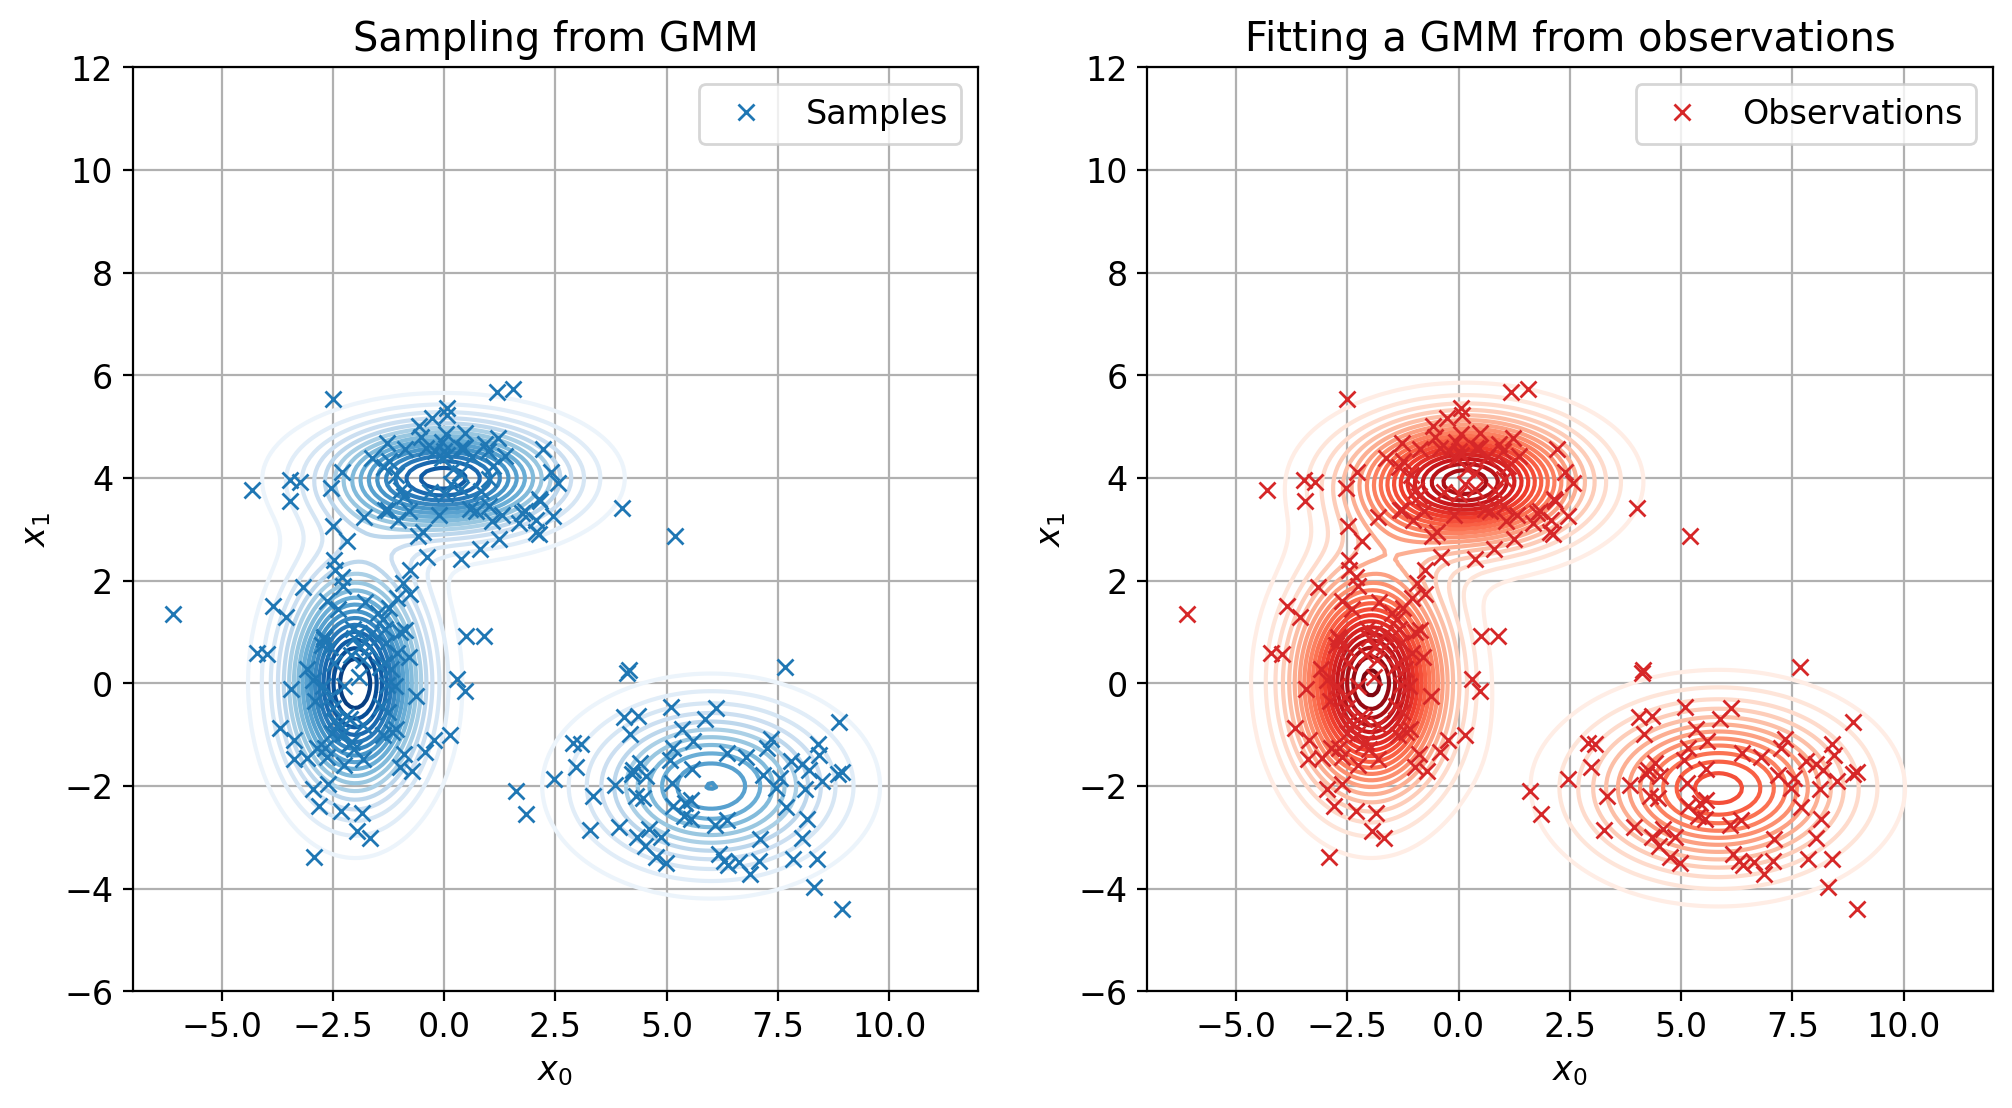

In [4]:
from sklearn.mixture import GaussianMixture as GMM


# Example of a GMM with K=3 and D=2
# Create a dataset of samples from a GMM with parameters:
mus = np.array([[0,4], [-2,0], [6,-2]])
sigmas = np.array([   [[3, 0], [0, 0.5]], [[1,0],[0,2]], [[3,0],[0,1]] ]) # Diagonal Sigma
pis = np.array([0.3, 0.4, 0.3])

# Sample data from this model (pi*N is the proportion of samples for each component)
N = 250
X_samples= np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*N))
                    for pi, mu, sigma in zip(pis, mus, sigmas)])

# Plot the original distribution
f, ax= plt.subplots(1,2, figsize=(12, 6))
intervals = 200
x0 = np.linspace(-6, 12, intervals)
x1 = np.linspace(-6, 12, intervals)
X0,X1 = np.meshgrid(x0,x1)
xs = np.vstack([X0.ravel(), X1.ravel()]).T
Y = np.zeros(len(xs))
for pi, mu, sigma in zip(pis, mus, sigmas):
    Y += pi*mvn(mu, sigma).pdf(xs)
Y = Y.reshape([intervals,intervals])
ax[0].contour(X0, X1, Y, 20, cmap='Blues')
ax[0].plot(X_samples[:, 0], X_samples[:, 1], 'x', color='tab:blue', label='Samples')
ax[0].grid()
ax[0].set_xlabel(r'$x_0$')
ax[0].set_ylabel(r'$x_1$')
ax[0].set_title('Sampling from GMM')
ax[0].legend(loc='best')

# Fit a new GMM observing the samples
# verbose=2 for learning purposes, if you prefer set verbose=0
gmm = GMM(n_components=3, covariance_type='diag', verbose=2, verbose_interval=1)
gmm.fit(X_samples)
pred_pis = gmm.weights_
pred_mus = gmm.means_
pred_sigmas = gmm.covariances_

# Plot the fitted GMM
Y = np.zeros(len(xs))
for pi, mu, sigma in zip(pred_pis, pred_mus, pred_sigmas):
    Y += pi*mvn(mu, sigma).pdf(xs)
Y = Y.reshape([intervals,intervals])
ax[1].contour(X0, X1, Y, 20, cmap='Reds')
ax[1].plot(X_samples[:, 0], X_samples[:, 1], 'x', color='tab:red', label='Observations')
ax[1].grid()
ax[1].set_xlabel(r'$x_0$')
ax[1].set_ylabel(r'$x_1$')
ax[1].set_title('Fitting a GMM from observations')
ax[1].legend(loc='best')

print('Original means: ')
print(mus)

print('Fitted means after ' + str(gmm.n_iter_) + ' EM iterations: ')
print(pred_mus)

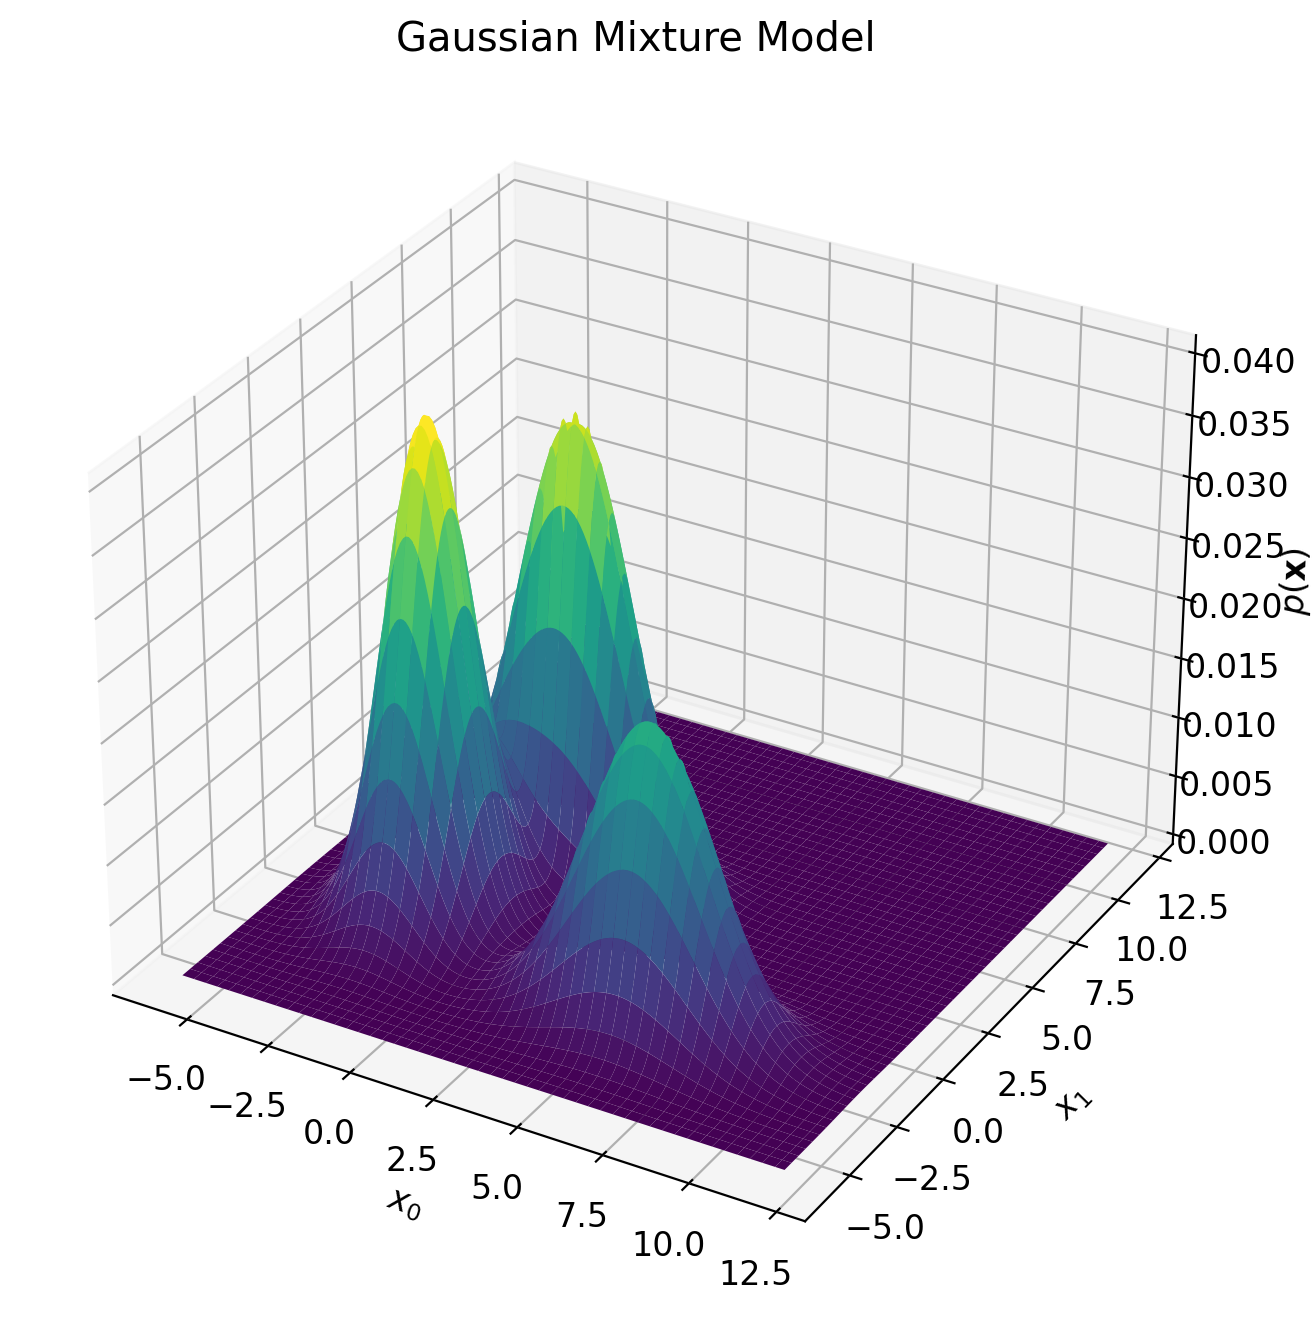

In [5]:
# PDF surfplace plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0, X1, Y, cmap='viridis')
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.set_zlabel(r'$p(\mathbf{x})$')
plt.title('Gaussian Mixture Model');


## 1.2. Choosing the number of components

An important question that typically arises when fitting a generative probabilistic model is how to select the right number of components. This problem is known as **model selection**.

A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, **using cross-validation to avoid over-fitting.** Namely, we evaluate the model log-likelihood for a validation set not used for training. 

Alternatively, the optimal Bayesian approach is to pick the model with the largest **marginal likelihood**:

\begin{align}
K^* = \arg\max_{K} p(\mathbf{X}|K) = \arg\max_{K} \int_{\mathbf{\theta}} p(\mathbf{X}|\mathbf{\theta},K) p(\mathbf{\theta}|K) d\mathbf{\theta}
\end{align}

In general, computing the marginal likelihood is quite difficult. Assuming a that prior distribution $p(\mathbf{\theta}|K)$ is Gaussian and very broad, we can approximate this term by the so-called **Bayessian Information Criterion** (BIC)
\begin{align}
-\log p(\mathbf{X}|K) \approx \frac{K\log N}{2}-\log p(\mathbf{X}|\mathbf{\theta}_{MAP},K)
\end{align}

where $\mathbf{\theta}_{MAP}$ is the mode of $p(\mathbf{\theta}|\mathbf{X},K)$, which is what we approximate with the EM (assuming again a very broad prior that does not weight much if the number of data points is large enough). **See Section 4.4.1. of Bishop's book for more details**. BIC is also very nicely derived in this [link](http://www.cs.toronto.edu/~mbrubake/teaching/C11/Handouts/BIC.pdf).

In summary:

- BIC gives us a way to choose between two differentmodels with different numbers of parameters by selecting the one whichgives us the **lowest BIC score**.

- More complex models are almost always likely to fit the data better (andtherefore have a lower value of $- \log p(\mathbf{X}|\mathbf{\theta}_{MAP},K)$).

- BIC gives us a relatively principled way to penalize these extra parameters in the form of the term $\frac{K\log N}{2}$. Note that this term doesn’t just penalize more parameters, italso says that if you have more data, you expect those extra parametersto help you that much more.

**Note: The BIC approximation is implemented in the GaussianMixture object of sklearn. Just call <code>model.bic(X)</code>.* 

## 1.3. Experiment: Clustering a Wine dataset

In this experiment, we're going to fit a GMM to the [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.


In [6]:
wines = pd.read_csv('wines.csv')
N=len(wines)
print('N='+str(N))
wines_data = wines.values
wines.head()

N=6497


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# Normalize the data
def normalize(data):
    mean = np.mean(data)
    var = np.var(data)
    data -= mean
    data /= var
    
    return data

wines_data = normalize(wines_data)


**TASK: Make a validation using the BIC criterion to choose the number of components that best explains the dataset. Use $K=[1, 2, .., 10]$. Plot the BIC curve.**

**Which is the optimal number of cluster to explain the wines dataset?**.

- The lower the BIC, the better, so for the wines dataset, the optimal number of clusters is 3.


Initialization 0
  Iteration 1	 time lapse 0.62414s	 ll change inf
  Iteration 2	 time lapse 0.22733s	 ll change 0.00000
Initialization converged: True	 time lapse 0.85247s	 ll 61.74390
Initialization 0
  Iteration 1	 time lapse 0.60846s	 ll change inf
  Iteration 2	 time lapse 0.01058s	 ll change 0.08492
  Iteration 3	 time lapse 0.00964s	 ll change 0.04464
  Iteration 4	 time lapse 0.01306s	 ll change 0.02353
  Iteration 5	 time lapse 0.02218s	 ll change 0.01202
  Iteration 6	 time lapse 0.00651s	 ll change 0.00628
  Iteration 7	 time lapse 0.00603s	 ll change 0.00337
  Iteration 8	 time lapse 0.00753s	 ll change 0.00186
  Iteration 9	 time lapse 0.01912s	 ll change 0.00104
  Iteration 10	 time lapse 0.00500s	 ll change 0.00059
Initialization converged: True	 time lapse 0.70811s	 ll 62.22941
Initialization 0
  Iteration 1	 time lapse 0.04624s	 ll change inf
  Iteration 2	 time lapse 0.00600s	 ll change 0.06287
  Iteration 3	 time lapse 0.01811s	 ll change 0.03118
  Iteration 4	 time 

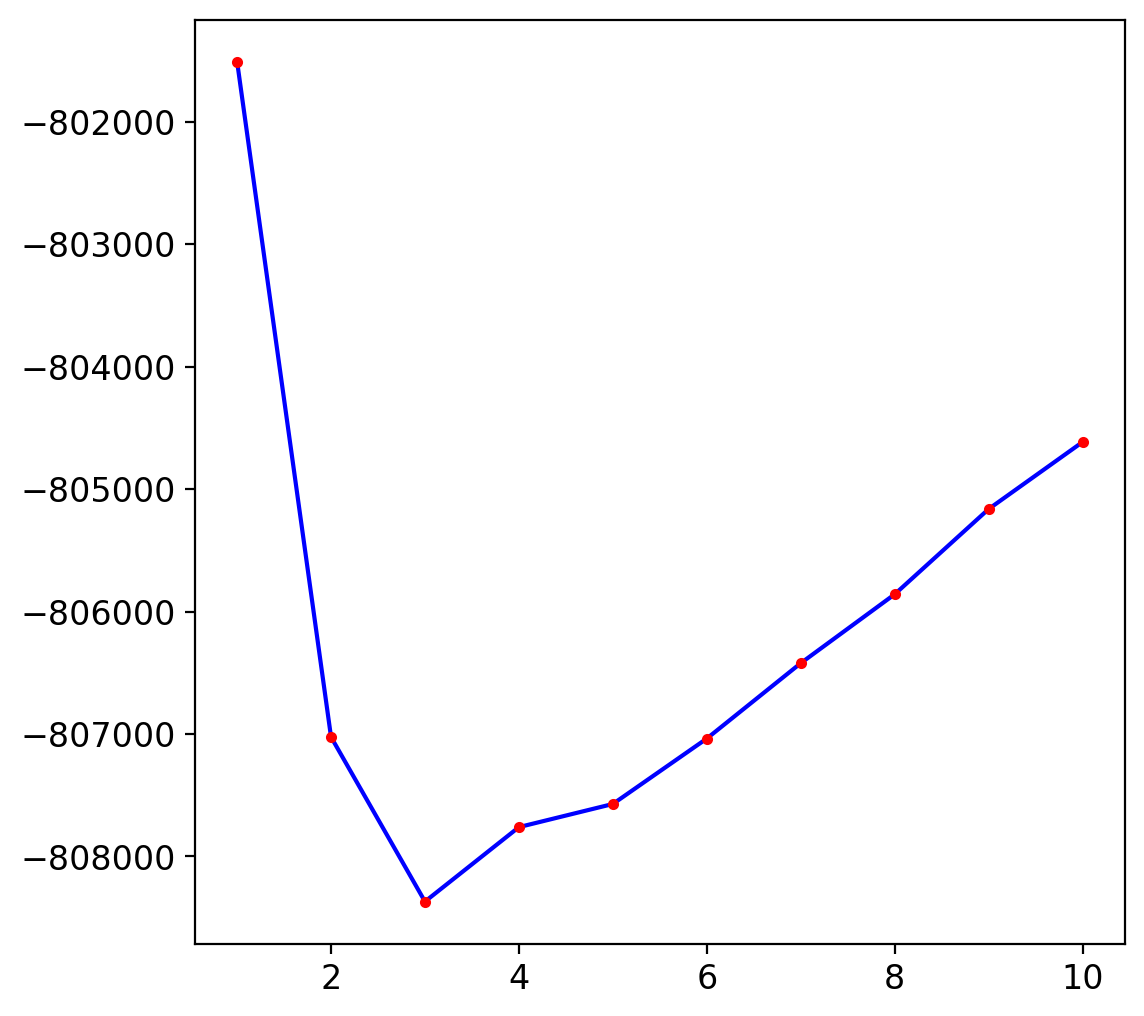

Lowest BIC: -808367.8367987572 for 3 components


In [8]:
k_list=np.array([1,2,3,4,5,6,7,8,9,10])
def bic_val(data, K_list):
    K=np.zeros(len(K_list))
    for k in range(len(K_list)):
        gmm = GMM(n_components=K_list[k], covariance_type='full', verbose=2, verbose_interval=1)
        model=gmm.fit(data) 
        K[k]=model.bic(data)
    return K

bic_list=bic_val(wines_data, k_list)
bic=np.amin(bic_list) #lowest bic
"""
print(bic_list)
print(bic)
"""
# Fit with polyfit
from numpy.polynomial.polynomial import polyfit
m, b = polyfit(k_list, bic_list, 1)


for i in range(0,len(k_list)-1):
    plt.plot([k_list[i], k_list[i+1]], [bic_list[i], bic_list[i+1]], color="blue")
plt.plot(k_list, bic_list, '.', color="red")

plt.show()

print("Lowest BIC:", bic, "for 3 components")

**For the selected $K$, compute the number of wines associated to each cluster.**


In [9]:
k = 3

gmm = GMM(n_components=k, covariance_type='diag', verbose=2, verbose_interval=1)
pred = gmm.fit_predict(wines_data)

c0=[]
c1=[]
c2=[]
for i in pred:
    if i==0: c0.append(i)
    if i==1: c1.append(i)
    if i==2: c2.append(i)

print("Number of wines in cluster 0:", len(c0))
print("Number of wines in cluster 1:", len(c1))
print("Number of wines in cluster 2:", len(c2))
print(len(c0)+len(c1)+len(c2)==len(wines_data))


Initialization 0
  Iteration 1	 time lapse 0.02062s	 ll change inf
  Iteration 2	 time lapse 0.00958s	 ll change 0.08558
  Iteration 3	 time lapse 0.00602s	 ll change 0.03369
  Iteration 4	 time lapse 0.00455s	 ll change 0.01697
  Iteration 5	 time lapse 0.00500s	 ll change 0.01036
  Iteration 6	 time lapse 0.00662s	 ll change 0.00679
  Iteration 7	 time lapse 0.00557s	 ll change 0.00476
  Iteration 8	 time lapse 0.01155s	 ll change 0.00354
  Iteration 9	 time lapse 0.00301s	 ll change 0.00276
  Iteration 10	 time lapse 0.00955s	 ll change 0.00223
  Iteration 11	 time lapse 0.00560s	 ll change 0.00184
  Iteration 12	 time lapse 0.02063s	 ll change 0.00154
  Iteration 13	 time lapse 0.00970s	 ll change 0.00130
  Iteration 14	 time lapse 0.01362s	 ll change 0.00109
  Iteration 15	 time lapse 0.00750s	 ll change 0.00091
Initialization converged: True	 time lapse 0.13912s	 ll 62.14394
Number of wines in cluster 0: 2418
Number of wines in cluster 1: 1170
Number of wines in cluster 2: 2909
T

## 1.3. Experiment: MRI Image segmentation

In GMMs, we can obtain the posterior probability to belong to each cluster for each observation, which may have some interpretability. One application of clustering algorithms is image segmentation, which consists on separating meaningful parts of an image. Each pixel in the image is substituted by the mean of the associated cluster (maximizing wrt $k$ the responsibilities $r_{ik}$).

For example, in MRI brain images, we can perform segmentation with GMMs by assigning the most probable cluster per datapoint, and this will give us an estimation of different parts of the brain (Cerebrospinal Fluid, Grey Matter, White Matter). These parts are usually extracted as a initial stage for other applications, as, for example, Alzheimer detection.

We are going to fit a GMM to a sample image from [IBSR dataset](https://www.nitrc.org/projects/ibsr).


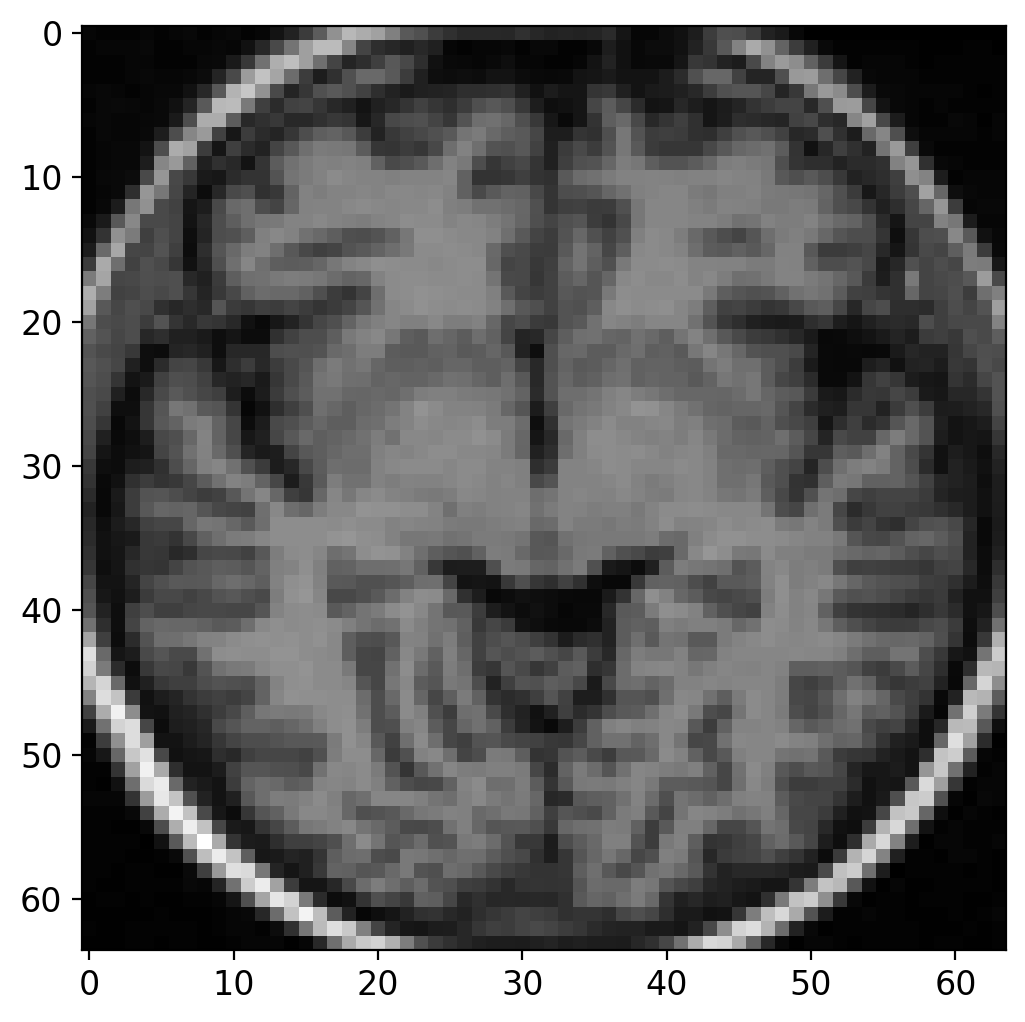

In [10]:
# Read the image
img=mpimg.imread('mri.png')
plt.gray()
plt.imshow(img)

# We want to obtain only the points inside the skull
X_all = np.reshape(img.copy(), [-1, 1])

# Set the background to black
out = X_all<0.035  # threshold to consider black
X_all[out] = 0

# Select pixels inside the skull
mask = X_all!=0 # This will filter black pixels
X = X_all[mask][:, np.newaxis]


**TASK: Validate the number of components $K$ using the BIC criterion, and for the chosen $K$, obtain the segmented representation of the brain image. Plot the original and segmented together to appreciate better the effect of segmentation. The components are supposed to represent, at least: the CSF, WM, GM and cortex tissues.**

Initialization 0
  Iteration 1	 time lapse 0.12281s	 ll change inf
  Iteration 2	 time lapse 0.00151s	 ll change 0.00000
Initialization converged: True	 time lapse 0.12432s	 ll 0.36419
Initialization 0
  Iteration 1	 time lapse 0.11331s	 ll change inf
  Iteration 2	 time lapse 0.00758s	 ll change 0.01624
  Iteration 3	 time lapse 0.00600s	 ll change 0.00410
  Iteration 4	 time lapse 0.00354s	 ll change 0.00174
  Iteration 5	 time lapse 0.01062s	 ll change 0.00099
Initialization converged: True	 time lapse 0.14106s	 ll 0.37503
Initialization 0
  Iteration 1	 time lapse 0.04186s	 ll change inf
  Iteration 2	 time lapse 0.02469s	 ll change 0.02939
  Iteration 3	 time lapse 0.01824s	 ll change 0.01007
  Iteration 4	 time lapse 0.00653s	 ll change 0.00530
  Iteration 5	 time lapse 0.00406s	 ll change 0.00340
  Iteration 6	 time lapse 0.00400s	 ll change 0.00244
  Iteration 7	 time lapse 0.00564s	 ll change 0.00189
  Iteration 8	 time lapse 0.00502s	 ll change 0.00154
  Iteration 9	 time lap

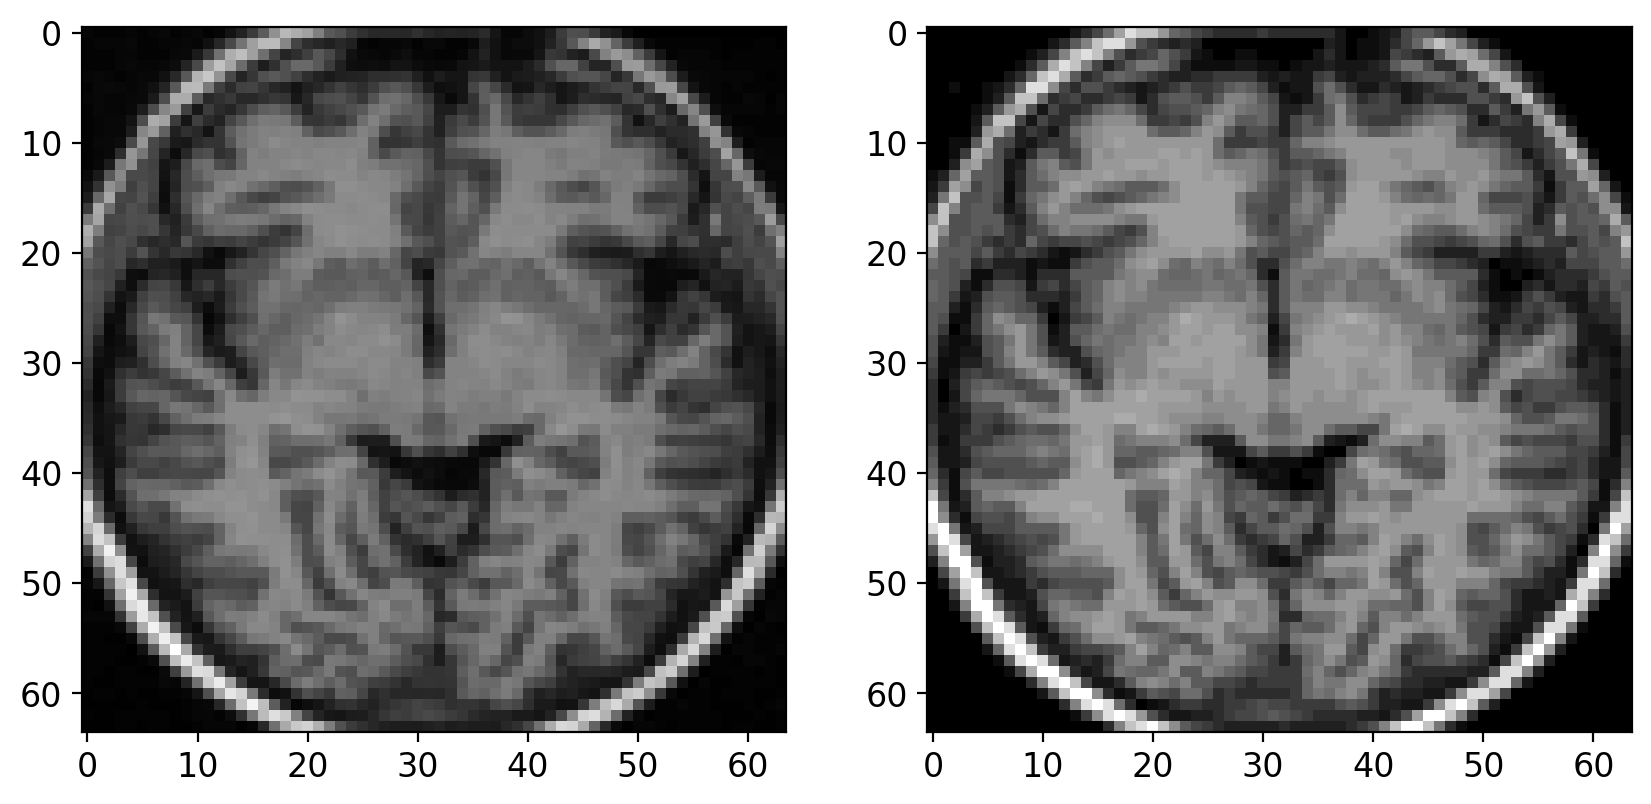

In [11]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)


k_list=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
bic=bic_val(X, k_list)#calculate the BIC for a list of possible components from 1 to 20
bic_min=np.amin(bic) #lowest bic
ind= np.where(bic == bic_min)
k=int(k_list[ind]) #OPTIMAL NUMBER OF COMPONENTS, RESULT O BIC

#model the data
gmm = GMM(n_components=k, covariance_type='diag', verbose=2, verbose_interval=1)
pred = gmm.fit_predict(X)
print("\nNUMBER OF COMPONENTS:", k)

# The data containing the corresponding mu for each point has to be stored in 'segm'
means = gmm.means_
segm = np.zeros_like(X)

for i in range(len(pred)):
    segm[i]=means[pred[i]]
    


# Add the background
segm_all = np.zeros_like(X_all)
segm_all[mask] = np.squeeze(segm)

# Reshape to original shape and plot
segm_all = np.reshape(segm_all, img.shape)
ax[1].imshow(segm_all);

## 1.4. K-Means

There is a popular variant of the EM algorithm for GMMs known as the K-means algorithm. Consider a GMM in which we make the following assumptions: $\Sigma_k=\sigma^2\textbf{I}$ (isotropic Gaussian) is *fixed*, and $\pi_k=1/K$ (uniform categorical) is *fixed*. Then, only the cluster centers, $\boldsymbol{\mu}_k \in \mathbb{R}^D$, have to be estimated. If we consider the following delta function approximation to the posterior computed during the E step:
\begin{equation}
p(zi=k | \mathbf{x}_i, \theta) \approx \mathbb{I}(k=z_i^*)
\end{equation}
where $z_i^* = \text{argmax}_k p(zi=k | \mathbf{x}_i, \theta)$. This is sometimes called **hard EM**, since we are making a hard assignment of points to clusters. Since we assumed an wqual spherical covariance matrix for each cluster, the most probable cluster for $\mathbf{x}_i$ can be computed by finding th nearest prototype:
\begin{equation}
z_i^* = \text{argmin}_k ||\textbf{x}_i - \mu_k||_2^2
\end{equation}
Hence, in each E step, we must find the Euclidean distance between N data points and $K$ cluster centers. Given the hard cluster assignments, the M step updates each cluster center by computing the mean of all points assigned to it:
\begin{equation}
\mu_k = \frac{1}{N_k}\sum_{i:z_i=k} \mathbf{x_i}
\end{equation}

There exists an class that implements [K-Means in Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).


## 1.5. Experiment: K-Means for image compression

In the next experiment you are going to compress an image using K-Means (a simpler version of a GMM, i.e. with fixed covariances and mixing weights). K-means assumes that every cluster (centroid) is equiprobable. We can use the number of centroids $K$ to represent a palette of colors, and represent the color for each pixel with the index of the nearest centroid $k$.

**TASK: Use the Lena sample image to obtain a compressed version with K=[64, 32, 16, 8, 4, 2] components, and plot each result.**

In [12]:
from sklearn.cluster import KMeans
import scipy.misc
from skimage import data

lena = mpimg.imread('lena.jpg')

plt.imshow(lena)
X = lena.reshape([-1, 3])
f, ax = plt.subplots(2, 3, figsize=(10, 5))

print(X.ndim)
print(X.shape)

K=np.array([64,32,16,8,4,2])
clustered=np.zeros(len(K)) #list with all the clustered images
print("First the original image in big, after that all together from left to right and first row, then second: \n64 components,32 components,16 components\n8 components,4 components,2 components")
for k, i in zip(K, range(len(K))):

    model = KMeans(n_clusters=k, random_state=0)
    pred = model.fit_predict(X)
    means = model.cluster_centers_
    pred = means[pred]
    pred = pred/np.amax(pred)
    X_c = np.reshape(pred, lena.shape)
    if i<=2:
        ax[0][i].imshow(X_c); 
    if i>=3:
        ax[1][i-3].imshow(X_c);





ModuleNotFoundError: No module named 'skimage'

# 2. Mixtures of Bernoulli distributions

In this par of the notebook notebook you will implement the EM algorithm for mixtures of Bernoulli distributions. This model is also known as [*latent class analysis*](https://en.wikipedia.org/wiki/Latent_class_model). As well as being of practical importance on its own right, understading this model and its learning also lay the fundation for **hidden Markov models (HMMs)** over discrete variables. HMMs will be dicussed in future course sessions.

Consider a set of i.i.d. $D$-dimensional binary (0-1) vectors. Examples of this kind of data are binary images, binary detection results, or genetic markers. Consider also a mixture of multinomials (or multivariate Bernoullis) model for each of the vectors, $\mathbf{x}$,

$$\displaystyle p(\mathbf{x} | \boldsymbol{\Theta},\mathbf{\pi} ) = \sum_{k=1}^K \pi_k p_k(\mathbf{x}^{(i)}|\boldsymbol{\theta}_k) = \sum_{k=1}^K \pi_k \prod_{j=1}^D \theta_{jk}^{x_{j}} (1-\theta_{jk})^{1-x_{j}},$$
where $\boldsymbol{\Theta}=[\boldsymbol{\theta}_1,\ldots,\boldsymbol{\theta}_K]$. If we are given a data set $\mathbf{X}=\{\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(N)}\}$ then the log likelihood function for this model is given by

\begin{align}
\log p(\mathbf{X}|\boldsymbol{\Theta},\mathbf{\pi}) = \sum_{i=1}^N \log\left(\sum_{k=1}^D \pi_k p(\mathbf{x}^{(i)}|\boldsymbol{\theta}_k)\right)
\end{align}

Again, we have te $\log$ of a sum, which remains non-convex and is hard to optimaze.

In contrast with to the GMM, in this model, we add an extra to prevent overfitting, we will also use a **prior distribution** for the model parameters. For $\boldsymbol{\Theta}$ we have

\begin{align}
\theta_{jk}&\sim\text{Beta}(\alpha,\beta)\\
p(\boldsymbol{\Theta}) &= \prod_{k=1}^{K} \prod_{j=1}^D p(\theta_{jk})\\
p(\theta_{jk}) &= \frac{\theta_{jk}^{\alpha-1}(1-\theta_{jk})^{\beta-1}}{\text{B}(\alpha,\beta)},
\end{align}
where $\text{B}(\alpha,\beta)$ is the [Beta function](https://en.wikipedia.org/wiki/Beta_function), that we have studied in previous sessions.

For $\mathbf{\pi}$ we use a uniform [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) (that we have also studied):
\begin{align} 
\mathbf{\pi}&\sim \text{Dir}(\frac{1}{K}, \ldots, \frac{1}{K}) \Rightarrow p(\mathbf{\pi}) =\frac{1}{\text{B}(\frac{1}{K}, \ldots, \frac{1}{K})}\prod_{k=1}^{K}\pi_k^{\frac{1}{K}-1},
\end{align}
where $\text{B}(\frac{1}{K}, \ldots, \frac{1}{K})$ is the multivariate Beta function.


We now derive the EM algorithm for maximizing the **posterior** distribution $p(\mathbf{\Theta},\mathbf{\pi}|\mathbf{X})$. To do this, we introduce an explict discrete latent variable $z\in\{1,\ldots,K\}$ associated to each data point $\mathbf{x}$:
\begin{align}
p(\mathbf{x},z) = \prod_{k=1}^{K} \left(\pi_k ~p_{k}(\mathbf{x})\right)^{\mathbb{1} [z==k]}, ~~ p(z)=\prod_{k=1}^K \pi_k^{\mathbb{1} [z==k]}
\end{align}

#### Complete log-likelihood

We write the complete data log-likelihood as follows:
\begin{align}
\log p(\mathbf{X},\mathbf{z}|\boldsymbol{\Theta},\mathbf{\pi})=\sum_{i=1}^{N}\sum_{k=1}^{K}\mathbb{1} [z^{(i)}==k]\left(\log \pi_k + \sum_{j=1}^D \left[x_{j}^{(i)}\log\theta_k+(1-x_{j}^{(i)})\log(1-\theta_k)\right]\right)
\end{align}

#### Posterior distribution of $\mathbf{z}$ given $\boldsymbol{\Theta},\mathbf{\pi}$

In the $E$-step, we have to compute the expected complete data log-likelihood w.r.t. posterior distribution of $\mathbf{z}$ given the current values of $\boldsymbol{\Theta},\mathbf{\pi}$:
\begin{align}
p(z^{(i)}=k|\mathbf{x}^{(i)},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)}) \triangleq r_{ik} = \frac{\pi_{(k,t-1)} p_k(\mathbf{x}|\boldsymbol{\theta}_k) }{\sum_{q=1}^K \pi_{(q,t-1)} p_k(\mathbf{x}^{(i)}|\boldsymbol{\theta}_q)}, ~~~ k=1,\ldots, K
\end{align}


## 2.1. The EM algorithm for a mixture of Bernouillis

#### E-step
It is easy to show that
\begin{align}
\mathcal{Q}(\boldsymbol{\Theta},\mathbf{\pi},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)})&=\mathbb{E}_{p(\mathbf{z}|\mathbf{X}^{(i)},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)})}[\log p(\mathbf{X},\mathbf{z}|\boldsymbol{\Theta},\mathbf{\pi})]\\
&=\sum_{i=1}^{N}\sum_{k=1}^K r_{ik} \left(\log \pi_k + \sum_{j=1}^D \left[x_{j}^{(i)}\log\theta_k+(1-x_{j}^{(i)})\log(1-\theta_k)\right]\right)
\end{align}

#### M-step

We have to find
\begin{align}
\boldsymbol{\Theta}_t,\mathbf{\pi}_t = \arg \max_{\boldsymbol{\Theta},\mathbf{\pi}} ~~\mathcal{Q}(\boldsymbol{\Theta},\mathbf{\pi},\boldsymbol{\Theta}_{(t-1)},\mathbf{\pi}_{(t-1)})+ \log p(\boldsymbol{\Theta})+\log p(\mathbf{\pi})
\end{align}

As a result, one can prove that the maximum is attained at

\begin{align}
r_k &\triangleq \sum_{i=1}^N r_{ik} \\\\
\pi^t_k &= \frac{r_k+\frac{1}{K}-1}{N+1-K}\\\\
\boldsymbol{\theta}_k &= \frac{\sum_{i=1}^N r_{ik}\mathbf{x}^{(i)}+\alpha-1}{r_k+\alpha+\beta-2} 
\end{align}

To see details about the derivation of this result, check out chapter 9 of Bishop's book. Also Chapter 11 of Murphy's book.

## 2.2. Experiment: Implementing the EM algorithm for a Mixture of Bernouillis

**TASK: Given the functions with all the steps implemented, build a higher-level function that performs the EM algorithm. The E-Step should compute $r_{ik}$, with $i=1,\ldots,N$, $k=1,\ldots,K$ for each data point. It should take as input the current values of $\boldsymbol{\pi}$, $\boldsymbol{\Theta}$, and the matrix $\mathbf{X}$ of observations. The M-Step should update the values of $\boldsymbol{\pi}$, $\boldsymbol{\Theta}$.**

In [19]:

def bernouilli_pdf(X,Thetak):
    M = np.exp(X*np.log(Thetak+1e-2)+(1-X)*np.log(1-Thetak+1e-2)) 
    P = np.prod(M,1)
    return P

def responsibilities(X,P,Theta,K):
    N,D = X.shape
    R = np.zeros([N,K])
    
    for k in range(K):
        R[:,k] = bernouilli_pdf(X,Theta[k,:])
                
    R *= P.T
    R /= np.sum(R,1).reshape([-1,1])    
    
    return R


In [20]:

def points_cluster(R):
    return np.sum(R,0)

def new_Pi(R,N):
    Rk = points_cluster(R)
    return Rk/N

def new_Theta(R,X,K,alpha,beta):
    N,D = X.shape
    Theta = np.zeros([K,D])
    Rk = points_cluster(R)

    for k in range(K):
        Theta[k,:] = (np.sum(X*R[:,k].reshape([-1,1]),0)+alpha-1) / (Rk[k]+alpha+beta-2)
    return Theta

def log_lik(X,P,Theta,K):
    LL = 0.
    for k in range(K):
        LL += bernouilli_pdf(X,Theta[k,:])*P[k]
    return np.sum(np.log(LL)) #Your code here


In [21]:

def EM_bernouilli(X, K, Niter):
    N,D = X.shape
    # Define the prior of Theta with alpha and beta
    alpha = 2.0
    beta = 2.0
    
    #############
    #           #
    # YOUR CODE #
    #           #
    #############
    
    # We intialize Theta; whose values are
    # bounded between 0 and 1
    np.random.seed(42)
    Theta = np.random.beta(alpha, beta, (K,D))
    # We intiailize Pi, the sum of its terms
    # is 1 given that we have K*1/K in the distribution
    Pi = np.random.dirichlet(np.full(K, 1/K))

    # We compute the initial log-likelihood
    #LL = log_lik(X,Pi,Theta,K)
    
    i = 0
    while (i <= Niter):
        
        ### E step ###

        # Evaluate the posterior probability
        R = responsibilities(X,Pi,Theta,K)
        
        ### M step ###
        Theta = new_Theta(R,X,K,alpha,beta)
        Pi = new_Pi(R,N)
        LL = log_lik(X,Pi,Theta,K)
        
        # Increase counter by 1
        i += 1
    
    return Pi, Theta, R, LL

## 2.3. EM for a Digits Dataset

In this section you will train a Mixture of Bernouillis to a binarized version of [digits dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html). 

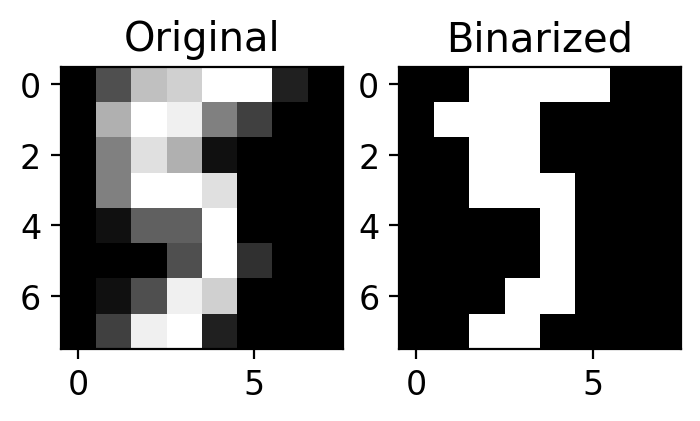

In [22]:
from sklearn.datasets import load_digits

# Load digits dataset
digits = load_digits()    #Gray scale, we have to binarize

D = digits.data.shape[-1]
N = digits.data.shape[0]

f, ax = plt.subplots(1, 2, figsize=(4, 2))
plt.gray() 
ax[0].imshow(digits.images[15])
ax[0].set_title('Original')

#Binarization
Bin_Images = np.copy(digits.images)
val_min=np.min(Bin_Images)
val_max=np.max(Bin_Images)
Bin_Images = (Bin_Images - val_min) / (val_max - val_min)
Bin_Images = np.round(Bin_Images)

ax[1].imshow(Bin_Images[15])
ax[1].set_title('Binarized')

# Reshape to obtain vector observations
X = Bin_Images.reshape([-1,D])


**TASK: Train a Mixture of Bernouillis for the digits dataset. Choose the number of clusters $K$ by common sense, without necessarily validating.**

In [23]:
#############
#           #
# YOUR CODE #
#           #
#############

# Sensible option, with K = 10, for each digit
K = 10
Niter = 1e3
BMM_Pi, BMM_Theta, BMM_R, BMM_LL = EM_bernouilli(X,K,Niter)

**TASK: Plot the negative log-likelihood obtained at each iteration using logarithmic y-axis (it should decrease). *Note: Compute it before E-Step.***

1001
1001


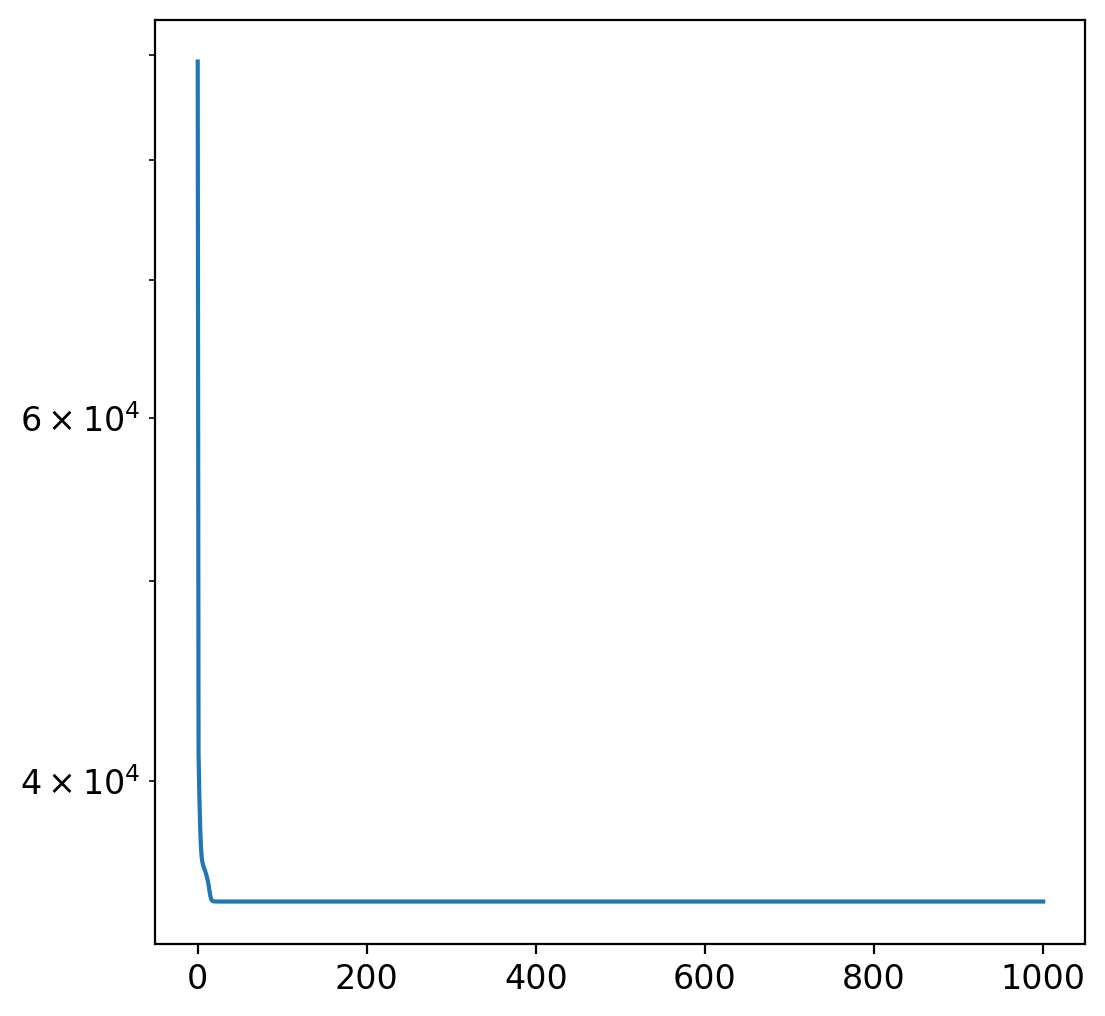

In [24]:
#############
#           #
# YOUR CODE #
#           #
#############
def EM_bernouilli_LL_Plot(X, K, Niter):
    N,D = X.shape
    # Define the prior of Theta with alpha and beta
    alpha = 2.0
    beta = 2.0
    
    # We intialize Theta; whose values are
    # bounded between 0 and 1
    Theta = np.random.beta(alpha, beta, (K,D))
    # We intiailize Pi, the sum of its terms
    # is 1 given that we have K*1/K in the distribution
    Pi = np.random.dirichlet(np.full(K, 1/K))
      
    #We compute the initial log-likelihood
    LL = log_lik(X,Pi,Theta,K)
    
    LL_list = []
    
    i = 0
    while (i <= Niter):
        LL_list.append(-LL)
        
        ### E step ###
        # Evaluate the posterior probability
        R = responsibilities(X,Pi,Theta,K)
        
        ### M step ###
        Theta = new_Theta(R,X,K,alpha,beta)
        Pi = new_Pi(R,N)
        LL = log_lik(X,Pi,Theta,K)
        
        # Increase counter by 1
        i += 1
        
    i_list = [i for i in range(len(LL_list))]
    
    print(len(LL_list))
    print(len(i_list))
    
    fig, ax = plt.subplots()
    ax.plot(i_list, LL_list)
    ax.set_yscale('log')

    plt.show()

    return

EM_bernouilli_LL_Plot(X, K, Niter)

We can see that the Negative Likelihood plot is monotonically decreasing which is theoretically guaranteed by the EM algorithm in the Bernoulli case. Each iteration is accompanied by an increase in the likelihood.

**TASK: Plot as a 8x8 gray-scale image each $\theta_k$ vector (reshaping from 64 to (8, 8)). It represents the probability for each pixel to be 1, for each cluster $k$.**

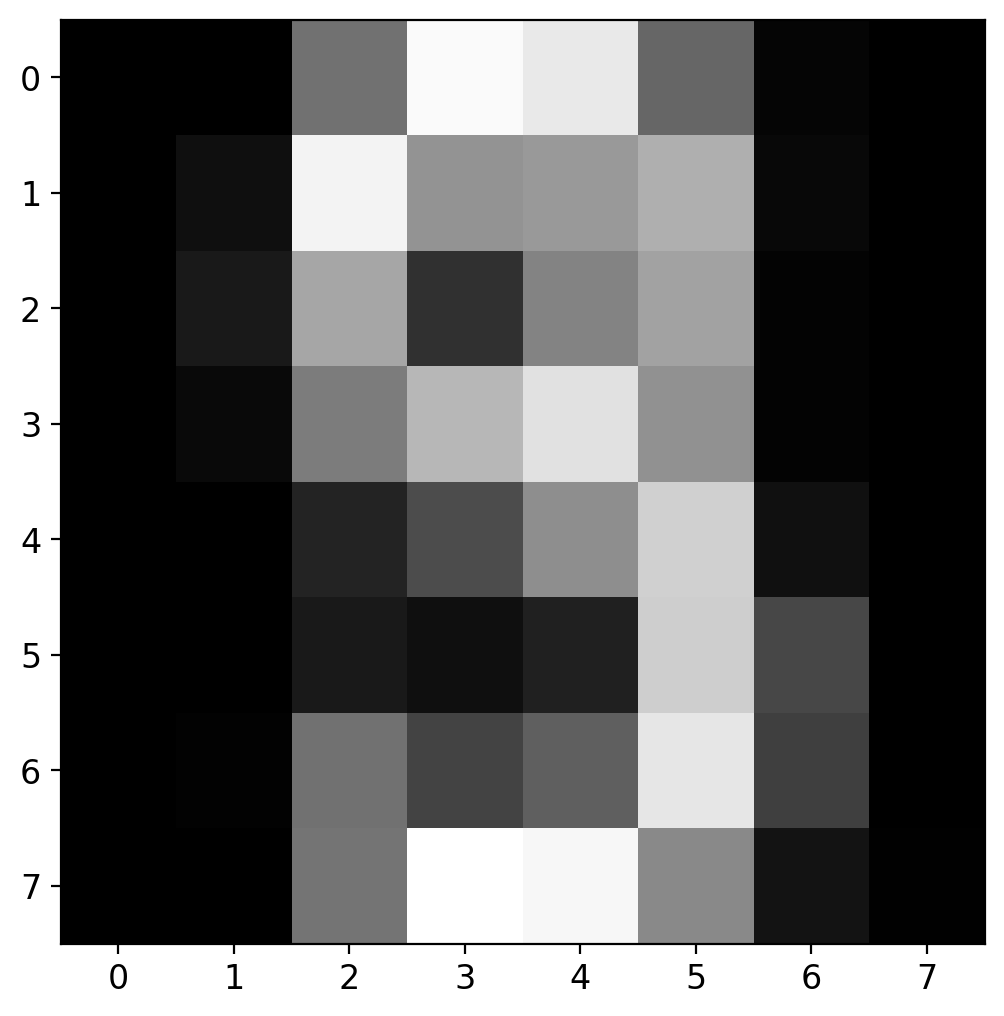

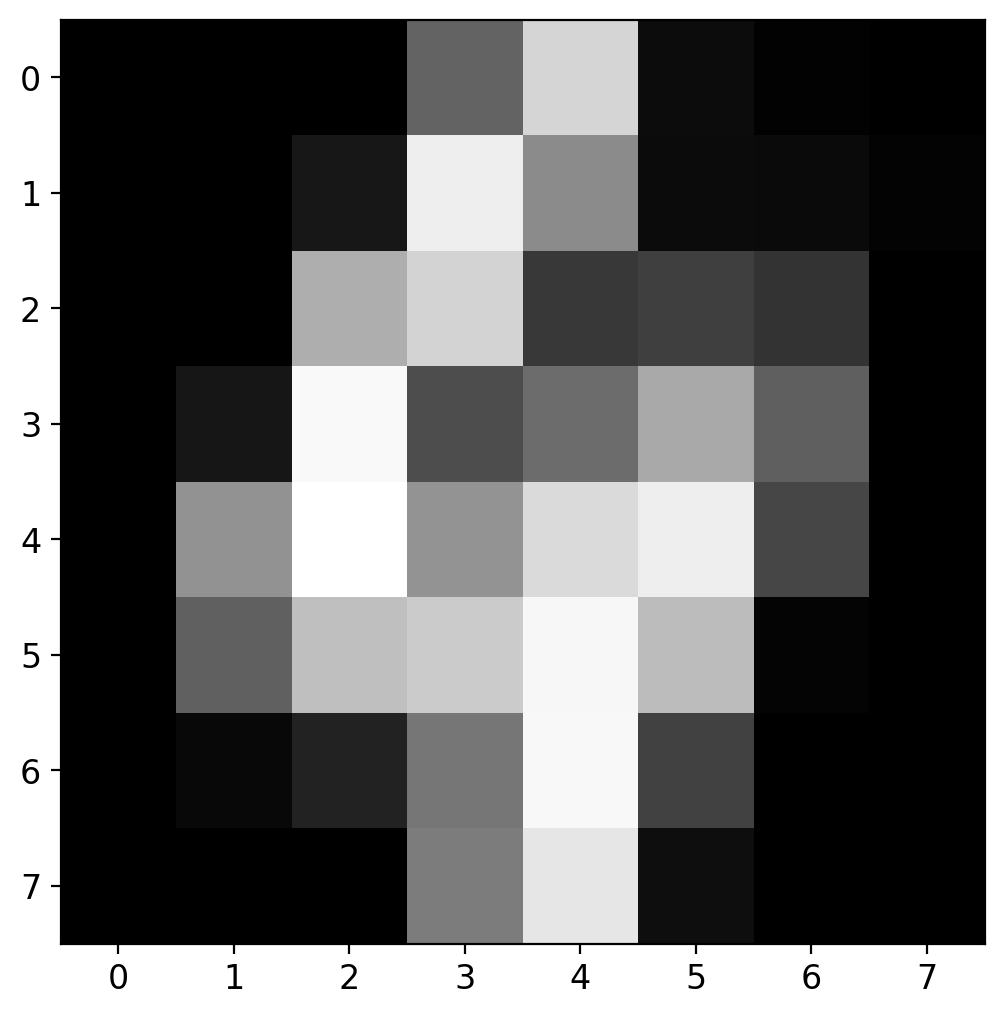

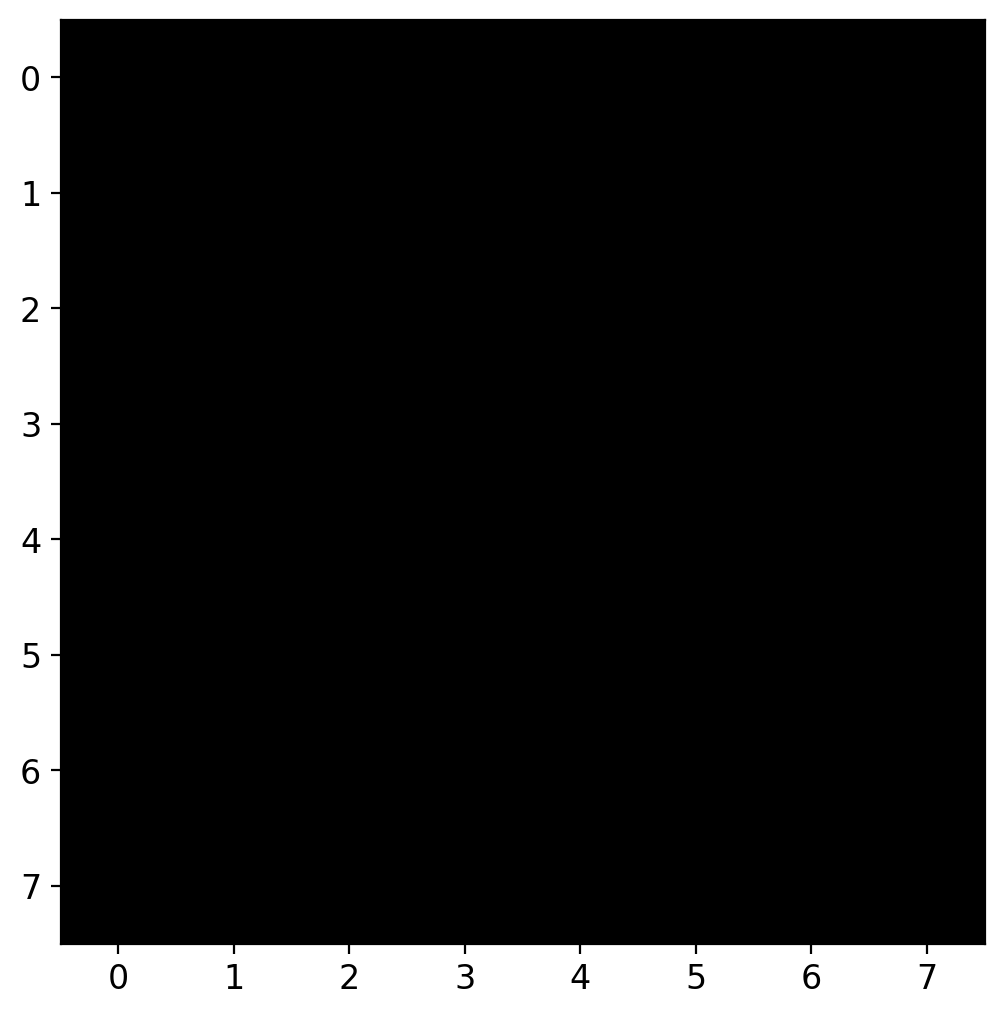

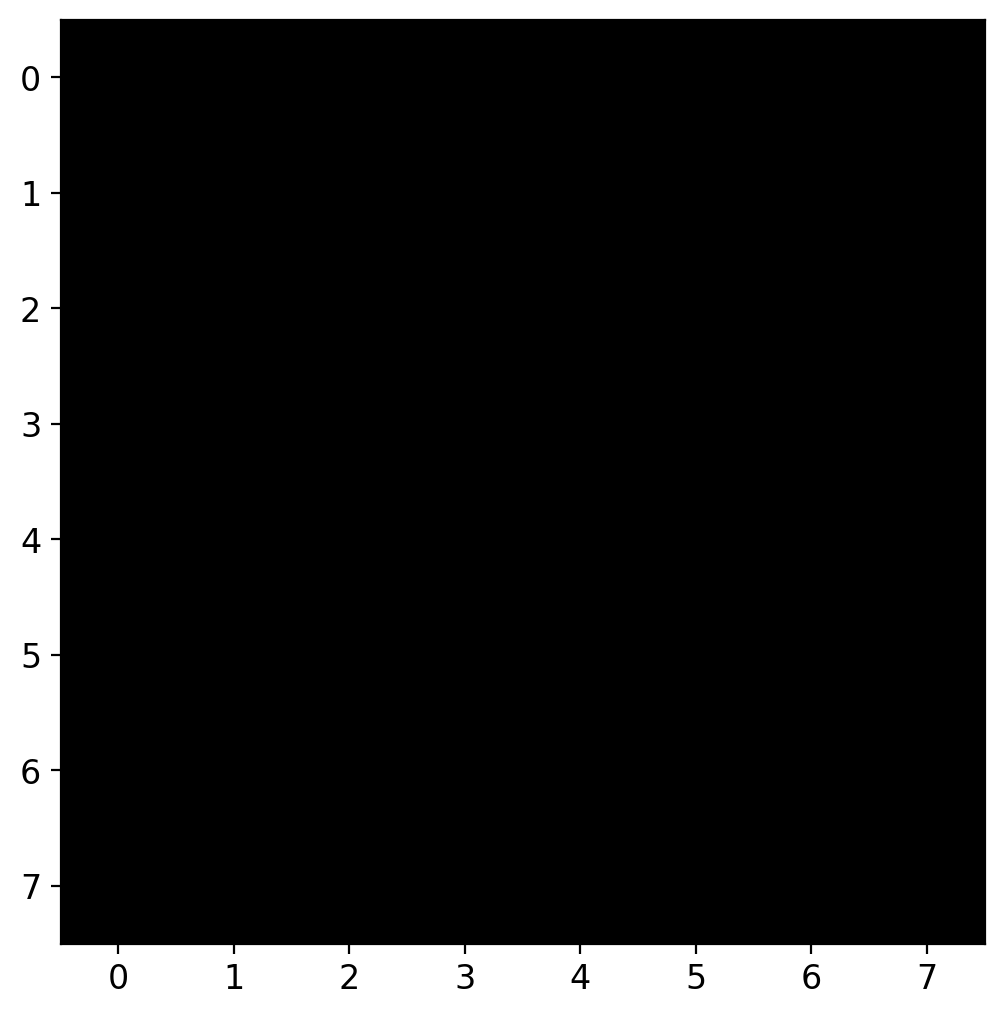

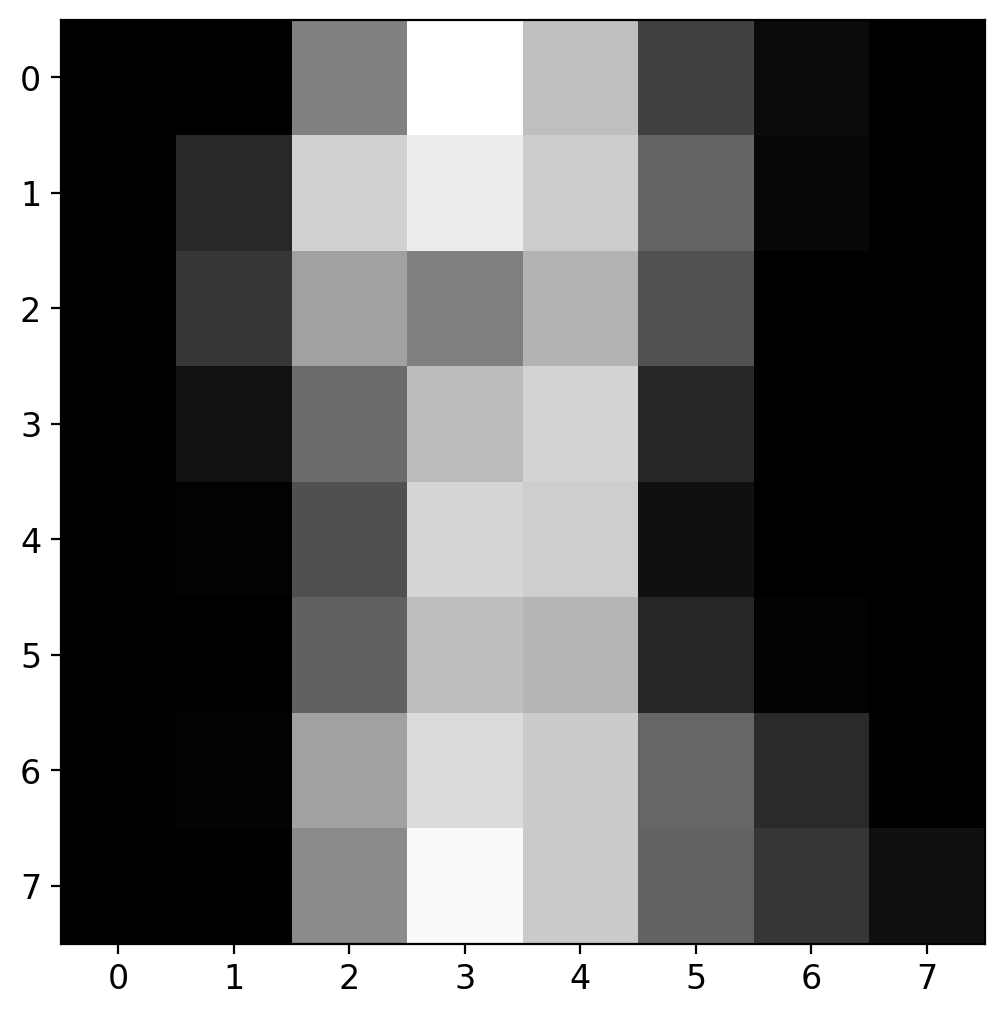

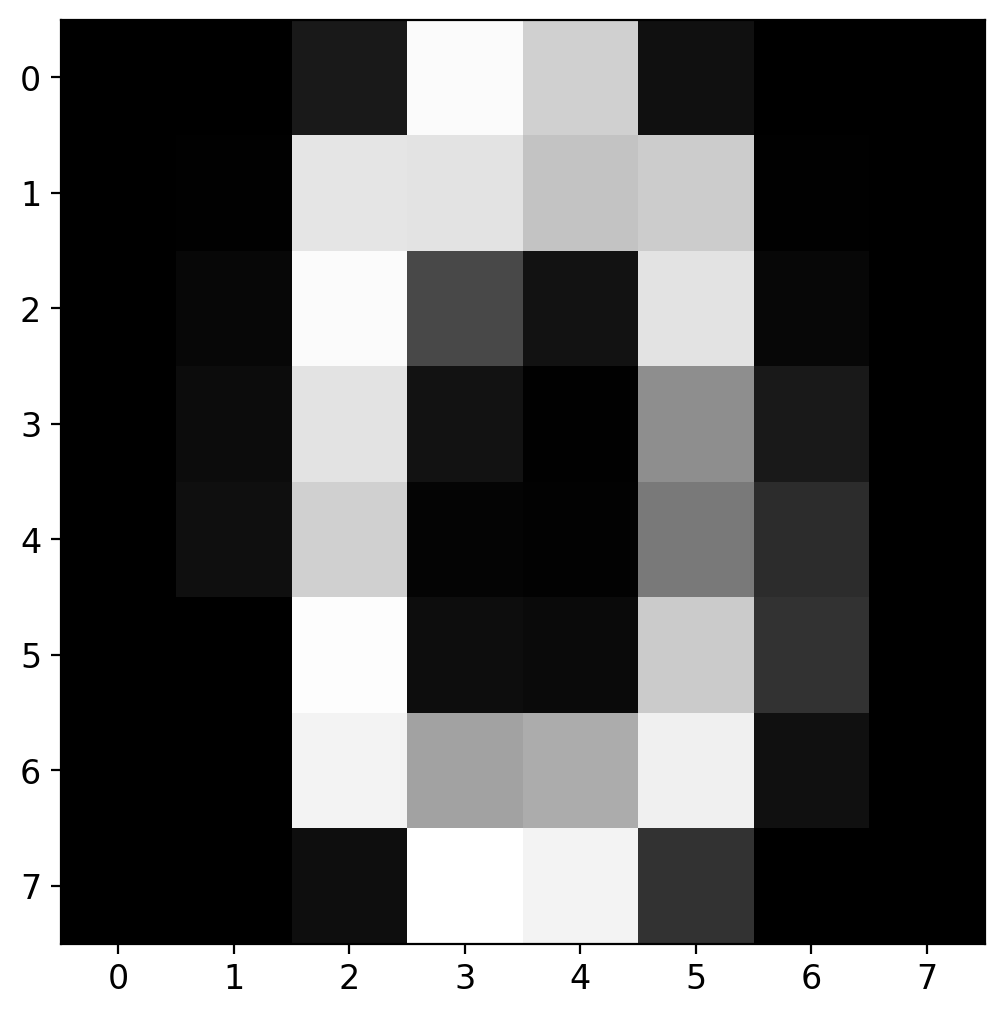

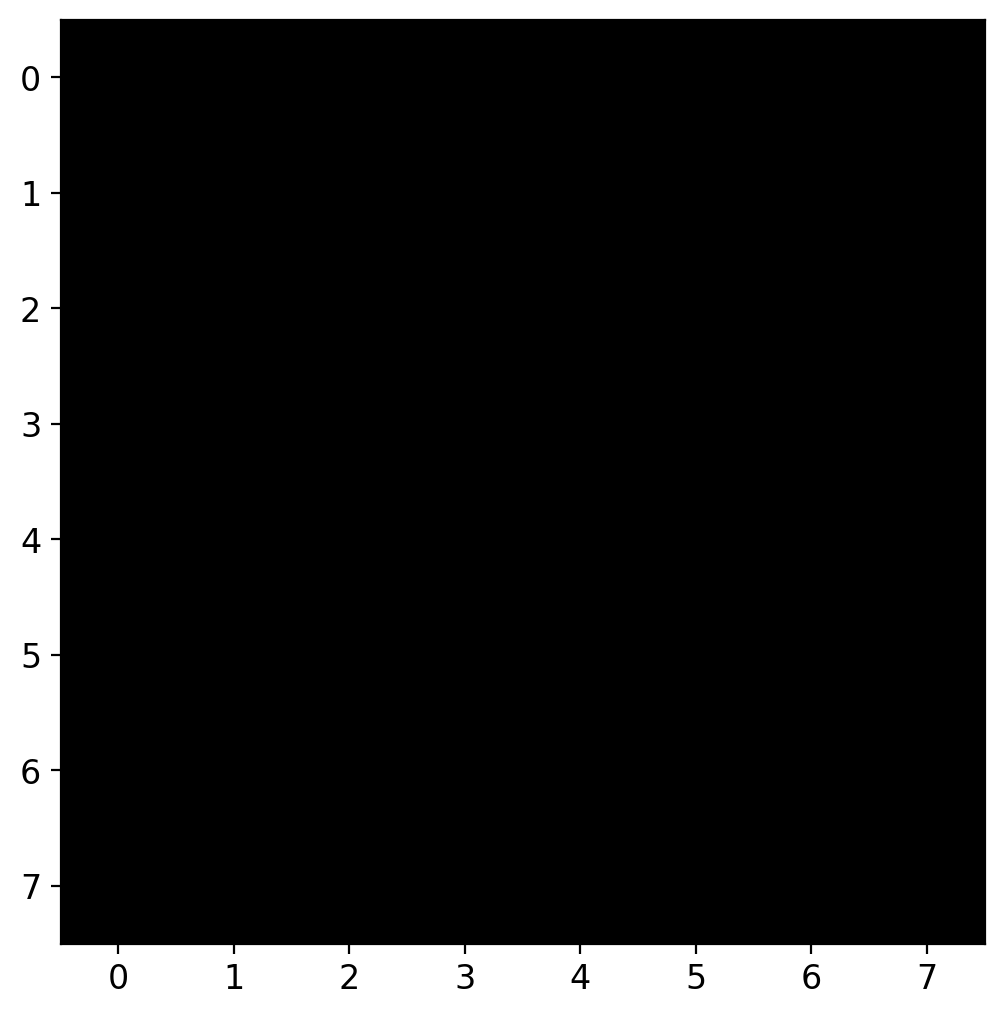

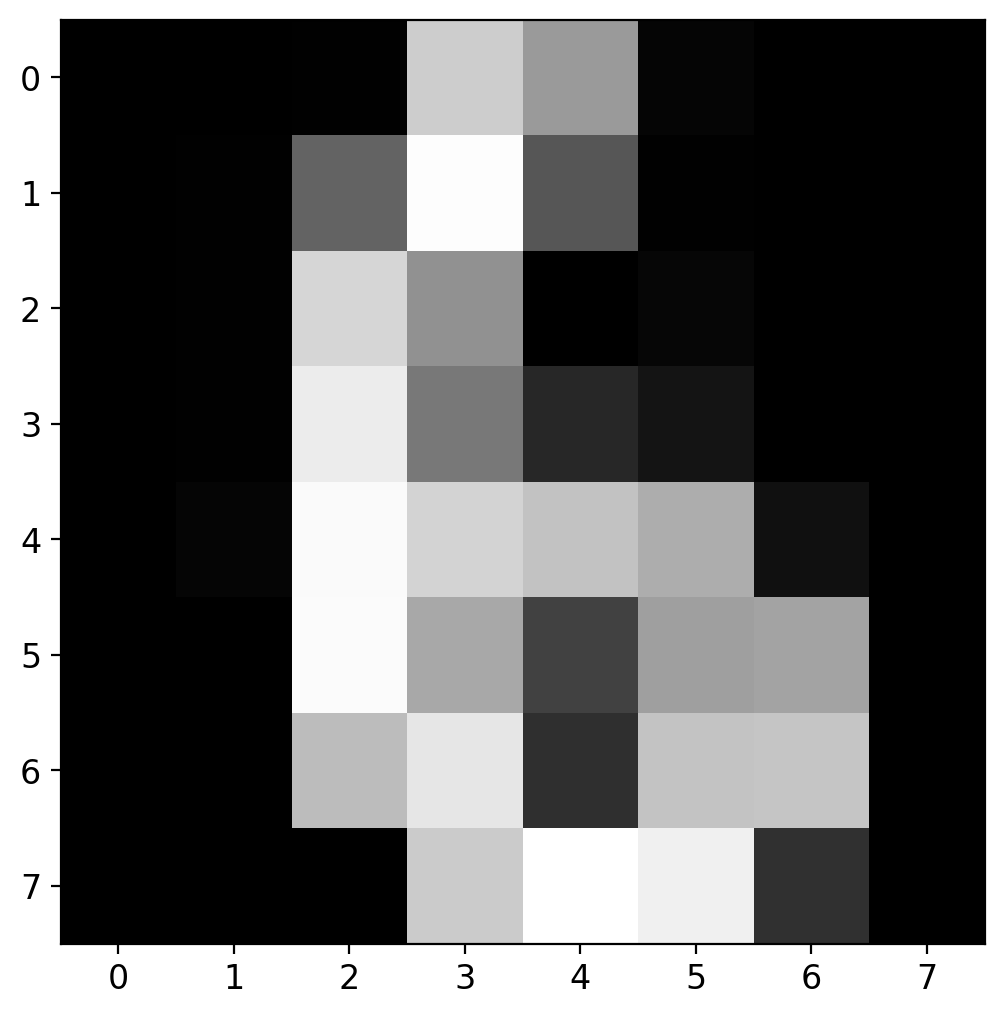

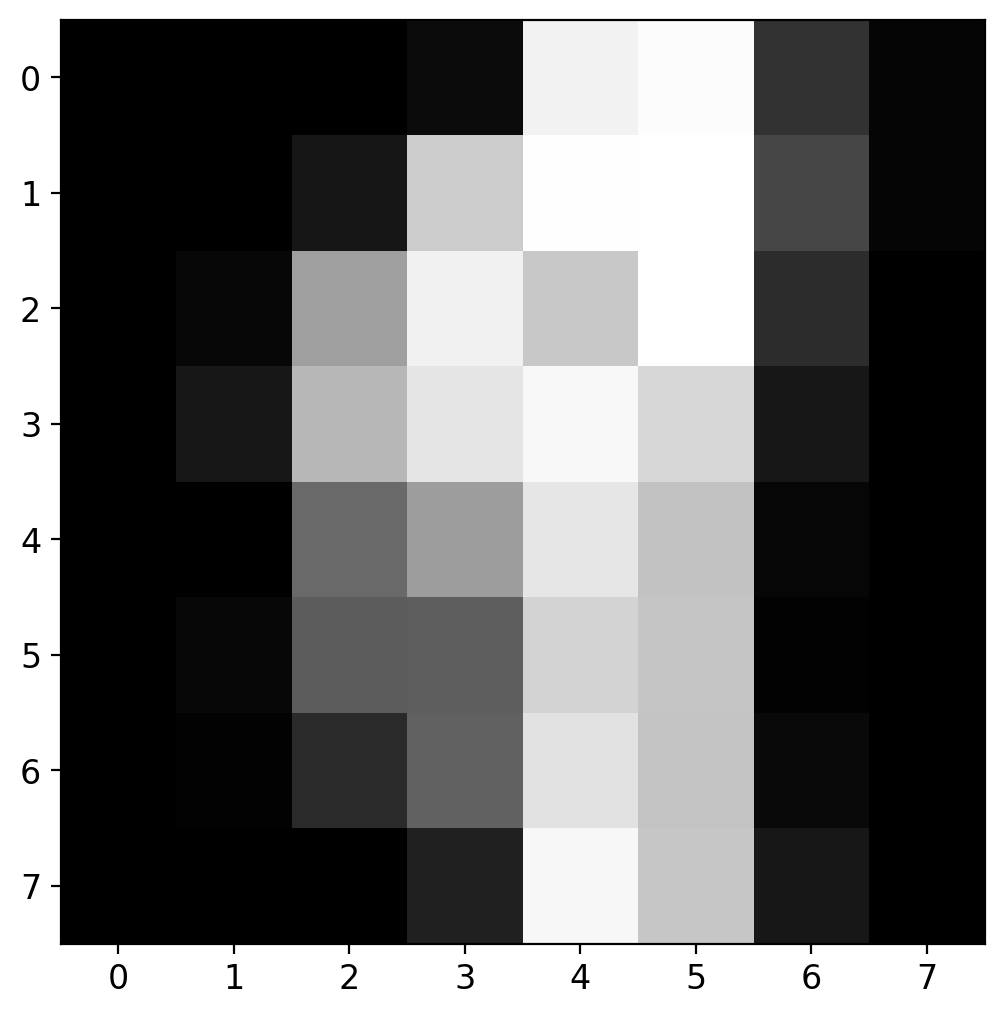

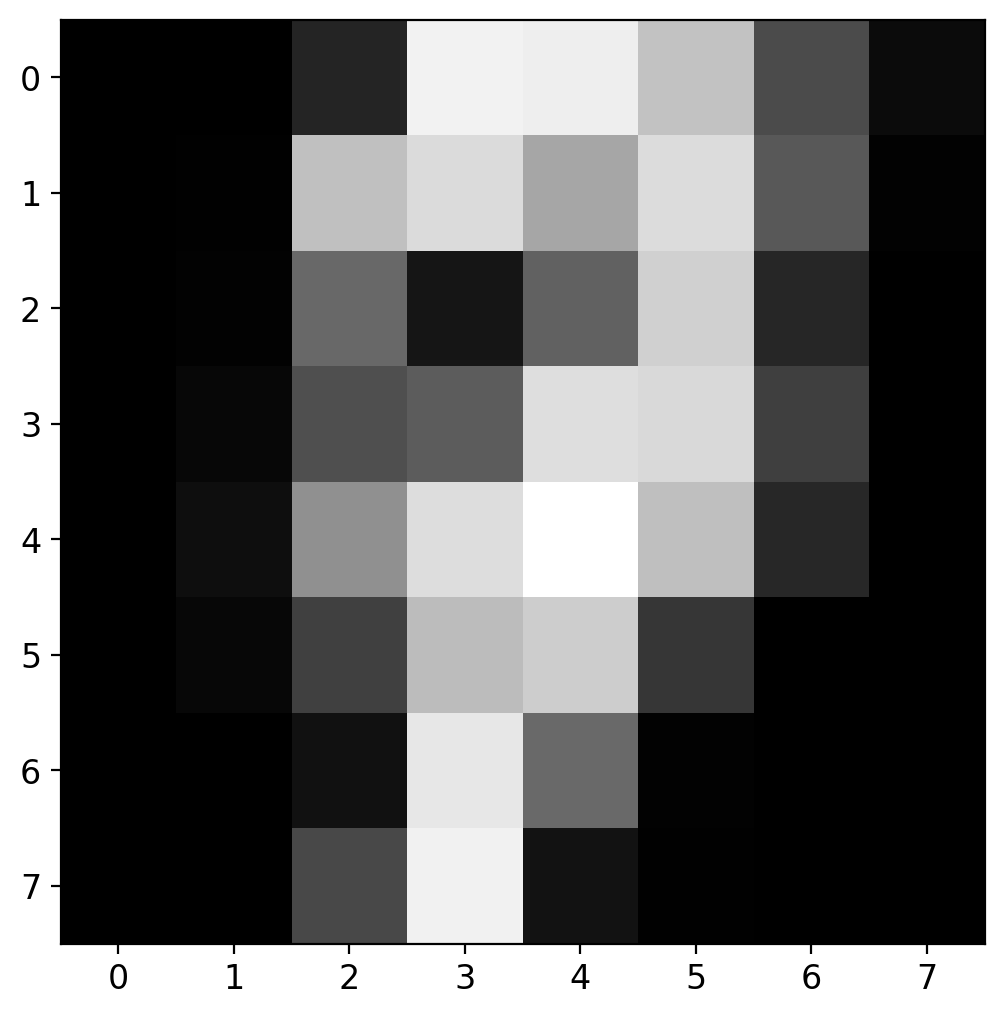

In [25]:
#############
#           #
# YOUR CODE #
#           #
#############

# For each cluster k
# take the kth vector of dimension 64,
# and reshape it to dimension (8,8)
# then plot it
for k in range(K):
    theta_reshaped = BMM_Theta[k].reshape(8,8)
    plt.imshow(theta_reshaped)
    plt.show()

## Comments

$K$ was chosen as $10$ because this is the number of different digits that we know the dataset to be made up of. It is possible to see that the BMM method was able to idenitify some of the digit classes but the results are far from perfect: there are some digits that did not get a cluster and others that in some executions got more than one.

Why is this the case? This caused by first:

1. This problem suffers from the fact that its likelihood function is not convex (remember the problem with the logarithm and the sum) and there is no closed-formula solution for it. The EM algorithm does a pretty good job but it still an approximation.

2. The simplicity of the model. This BMM model is not taking into account the fact that pixels should not be considered as being totally independent, as in handwriting they are often related via common traces (alphabets) and stroke (Chinese characters).

2. Maybe more clusters are needed for different variations of a single class. For example, digits 7 and 0 can be written in different ways.

How could this be addressed?

As in other cases that arise in similar circumstances, an informed selection of a particular prior is helpful - especially when having less samples. Using a mix of unsupervised and supervised methods such as in the OCSVM case could also be useful.

## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

